In [35]:
import numpy as np
import matplotlib.pyplot as plt
from ler.rates import LeR
from ler.utils import get_param_from_json, append_json

In [36]:
ler = LeR(event_type="BNS", verbose=False)

In [37]:
# mu_dict = {"magnifications": np.array([])}
# # save json
# append_json("./ler_data/magnifications.json", mu_dict, replace=True);

In [40]:
get_param_from_json("./ler_data/magnifications.json")["magnifications"]

array([], dtype=float64)

In [39]:
ler.batch_size = 100000
mu_arr = get_param_from_json("./ler_data/magnifications.json")["magnifications"]
while len(mu_arr)<50000:
    lensed_params = ler.lensed_cbc_statistics(size=100000)
    mu = np.log10(abs(lensed_params["magnifications"].flatten()))
    idx = (mu > 2) & (mu < 5)
    mu = mu[idx]
    print('len(mu) at this batch: ',len(mu))
    mu_dict = {"magnifications": mu}
    mu_arr = append_json("./ler_data/magnifications.json", mu_dict)["magnifications"]
    print(f'len(mu_arr) total: {len(mu_arr)} \n')

lensed params will be store in ./ler_data/lensed_param.json
chosen batch size = 100000 with total size = 100000
There will be 1 batche(s)
Batch no. 1
sampling lensed params...


KeyboardInterrupt: 

0


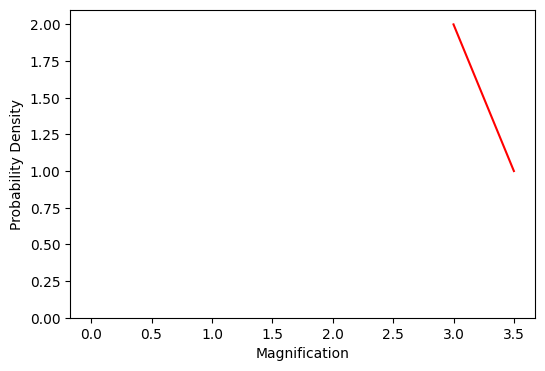

In [41]:
mu = get_param_from_json("./ler_data/magnifications.json")["magnifications"]
idx = (mu > 3) & (mu < 3.5)
mu = mu[idx]
print(len(mu))
log10_mu_arr = np.linspace(3, 3.5, 100)
mu_arr = 10**log10_mu_arr
pdf = np.log10(mu_arr**(-2))+8

# plot the magnification distribution
plt.figure(figsize=(6, 4))
plt.hist(mu, bins=20, density=True, histtype="step", color="black")
plt.plot(log10_mu_arr, pdf, color="red", label=r"$\propto \mu^{-2}$")
plt.xlabel("Magnification")
plt.ylabel("Probability Density")
#plt.title("Magnification Distribution")
plt.show()